In [1]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RepeatedKFold, LeaveOneOut
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
import os
import sys

# Add project root to path (for Jupyter notebooks)
# Get the current directory and navigate to project root
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)

from src.config import Config
import src.eda as eda
import src.present_value as present_value

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


c:\Users\forer\anaconda3\envs\practicum\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
## FROM DATABASE
pv = present_value.PresentValue()
anual_increment = pv.fetch_incremento_from_database()

fase = "III"
preproccesing = eda.EDA()
df_raw = preproccesing.assemble_projects_from_database(fase)
df_vp = preproccesing.create_dataset(pv.present_value_costs, fase=fase)

c:\Code\Road-Project-Prediction\src\eda.py:286: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [3]:
df = df_vp[df_vp['CÓDIGO'] != '0005']
df = df[['LONGITUD KM', 'ALCANCE']].join(df.loc[:, '1 - TRANSPORTE':'16 - DIRECCIÓN Y COORDINACIÓN'])
df

,LONGITUD KM,ALCANCE,1 - TRANSPORTE,2.1 - INFORMACIÓN GEOGRÁFICA,2.2 - TRAZADO Y DISEÑO GEOMÉTRICO,2.3 - SEGURIDAD VIAL,2.4 - SISTEMAS INTELIGENTES,3.1 - GEOLOGÍA,3.2 - HIDROGEOLOGÍA,4 - SUELOS,...,7 - SOCAVACIÓN,8 - ESTRUCTURAS,9 - TÚNELES,10 - URBANISMO Y PAISAJISMO,11 - PREDIAL,12 - IMPACTO AMBIENTAL,13 - CANTIDADES,14 - EVALUACIÓN SOCIOECONÓMICA,15 - OTROS - MANEJO DE REDES,16 - DIRECCIÓN Y COORDINACIÓN
0,17.400,Segunda calzada,0.000000e+00,0.000000e+00,1.353405e+08,7.287564e+07,4.013575e+07,1.239362e+08,0.000000e+00,1.878437e+08,...,5.275975e+07,6.838215e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.377238e+07,0.000000e+00,5.027965e+07,1.714043e+08
1,13.690,Nuevo,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.443049e+07,6.507553e+07,0.000000e+00,1.937793e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.634289e+08
9,5.000,Mejoramiento,0.000000e+00,0.000000e+00,6.311029e+06,2.105373e+06,0.000000e+00,1.385817e+07,0.000000e+00,1.326106e+07,...,6.289853e+06,6.421774e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.901125e+07,6.672842e+06
10,2.500,Segunda calzada,0.000000e+00,0.000000e+00,1.814013e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.532367e+07,...,9.159642e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.250960e+07
11,17.000,Segunda calzada,0.000000e+00,0.000000e+00,8.023420e+07,1.158669e+07,0.000000e+00,4.968315e+07,0.000000e+00,1.308015e+08,...,4.467656e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.775515e+07
12,50.900,Mejoramiento,0.000000e+00,0.000000e+00,1.134648e+08,6.109646e+07,3.344233e+07,0.000000e+00,0.000000e+00,0.000000e+00,...,1.640687e+08,3.872771e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.132408e+07
13,9.000,Mejoramiento,0.000000e+00,0.000000e+00,2.006255e+07,1.080291e+07,5.913181e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,2.901019e+07,6.847729e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.306812e+06
14,21.000,Mejoramiento,0.000000e+00,0.000000e+00,4.681261e+07,2.520679e+07,1.379742e+07,0.000000e+00,0.000000e+00,0.000000e+00,...,6.769043e+07,1.597804e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.704923e+07
15,14.000,Mejoramiento,0.000000e+00,0.000000e+00,3.120841e+07,1.680453e+07,9.198282e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,4.512696e+07,1.065202e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.136615e+07
16,6.560,Mejoramiento,0.000000e+00,0.000000e+00,1.462337e+07,7.874121e+06,4.310052e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,2.114520e+07,4.991234e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.325854e+06


In [32]:
def remove_outliers(df, target: str, method='ensemble', contamination=0.1, voting_threshold=0.5) -> pd.DataFrame:
    """
    Advanced outlier detection using multiple methods.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    target : str
        Target column name
    method : str
        'ensemble' (default): Combines multiple methods with voting
        'isolation_forest': Uses Isolation Forest only
        'lof': Uses Local Outlier Factor only
        'robust_statistical': Uses Modified Z-score with MAD
        'all_strict': All methods must agree (strictest)
    contamination : float
        Expected proportion of outliers (0.05-0.2 typical)
    voting_threshold : float
        For ensemble method, fraction of methods that must flag as outlier (0.5 = majority)
    
    Returns:
    --------
    pd.DataFrame
        Cleaned dataframe without outliers
    """
    from sklearn.ensemble import IsolationForest
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.preprocessing import StandardScaler
    
    # Remove zero values first (domain-specific)
    df_nonzero = df[df[target] != 0].copy()
    
    if len(df_nonzero) < 10:
        print(f"Warning: Only {len(df_nonzero)} samples. Skipping outlier detection.")
        return df_nonzero
    
    # Prepare features: numerical columns + target
    numerical_cols = df_nonzero.select_dtypes(include=[np.number]).columns.tolist()
    
    # Scale features for better outlier detection
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_nonzero[numerical_cols])
    
    # Initialize outlier flags
    outlier_flags = {}
    
    # Method 1: Isolation Forest (excellent for high-dimensional data)
    if method in ['ensemble', 'isolation_forest', 'all_strict']:
        iso_forest = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=200,
            max_samples='auto',
            bootstrap=True
        )
        iso_predictions = iso_forest.fit_predict(X_scaled)
        outlier_flags['isolation_forest'] = (iso_predictions == -1)
        
    # Method 2: Local Outlier Factor (density-based, good for local anomalies)
    if method in ['ensemble', 'lof', 'all_strict']:
        n_neighbors = min(20, len(df_nonzero) - 1)
        lof = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination
        )
        lof_predictions = lof.fit_predict(X_scaled)
        outlier_flags['lof'] = (lof_predictions == -1)
    
    # Method 3: Modified Z-score with MAD (robust to outliers themselves)
    if method in ['ensemble', 'robust_statistical', 'all_strict']:
        target_values = df_nonzero[target].values
        median = np.median(target_values)
        mad = np.median(np.abs(target_values - median))
        
        # Modified Z-score (more robust than standard Z-score)
        if mad != 0:
            modified_z_scores = 0.6745 * (target_values - median) / mad
            # Threshold of 3.5 is standard for modified Z-score
            outlier_flags['robust_statistical'] = np.abs(modified_z_scores) > 3.5
        else:
            outlier_flags['robust_statistical'] = np.zeros(len(df_nonzero), dtype=bool)
    
    # Method 4: Multivariate Z-score on target (additional check)
    if method in ['ensemble', 'all_strict']:
        target_scaled = scaler.fit_transform(df_nonzero[[target]])
        outlier_flags['z_score'] = np.abs(target_scaled.flatten()) > 3
    
    # Combine methods based on selected strategy
    if method == 'ensemble':
        # Voting: flag as outlier if voting_threshold fraction of methods agree
        outlier_matrix = np.column_stack(list(outlier_flags.values()))
        votes = outlier_matrix.sum(axis=1)
        is_outlier = votes >= (len(outlier_flags) * voting_threshold)
        
    elif method == 'all_strict':
        # All methods must agree (most conservative)
        outlier_matrix = np.column_stack(list(outlier_flags.values()))
        is_outlier = outlier_matrix.all(axis=1)
        
    elif method in ['isolation_forest', 'lof', 'robust_statistical']:
        # Single method
        is_outlier = outlier_flags[method]
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Filter out outliers
    df_clean = df_nonzero[~is_outlier].copy()
    
    # Report
    n_outliers = is_outlier.sum()
    pct_removed = (n_outliers / len(df_nonzero)) * 100
    print(f"  → Removed {n_outliers}/{len(df_nonzero)} outliers ({pct_removed:.1f}%) using {method}")
    
    if method == 'ensemble' and len(outlier_flags) > 1:
        for flag_name, flags in outlier_flags.items():
            print(f"     • {flag_name}: {flags.sum()} outliers")
    
    return df_clean

## Advanced Outlier Detection Methods

The `remove_outliers()` function now uses sophisticated techniques:

### **Methods Available:**
1. **`ensemble`** (default) - Combines 4 methods with voting:
   - Isolation Forest: Tree-based anomaly detection
   - Local Outlier Factor (LOF): Density-based detection
   - Modified Z-score with MAD: Robust statistical method
   - Multivariate Z-score: Additional check on target variable
   
2. **`isolation_forest`** - Single method using Isolation Forest
3. **`lof`** - Single method using Local Outlier Factor
4. **`robust_statistical`** - Single method using Modified Z-score with MAD
5. **`all_strict`** - Most conservative: ALL methods must agree

### **Usage Examples:**

```python
# Default: Ensemble with majority voting (50%)
df_clean = remove_outliers(df, target='11 - PREDIAL')

# More aggressive: Remove if 2+ methods agree (lower threshold)
df_clean = remove_outliers(df, target='11 - PREDIAL', voting_threshold=0.4)

# Conservative: Higher contamination expected, stricter voting
df_clean = remove_outliers(df, target='11 - PREDIAL', contamination=0.15, voting_threshold=0.6)

# Use single method only
df_clean = remove_outliers(df, target='11 - PREDIAL', method='isolation_forest')

# Most strict: All methods must agree
df_clean = remove_outliers(df, target='11 - PREDIAL', method='all_strict')
```

### **Parameters:**
- `contamination` (0.05-0.2): Expected proportion of outliers
- `voting_threshold` (0.0-1.0): Fraction of methods that must agree (ensemble only)


In [28]:
def rmsle_scorer(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def train_model(df_clean, predictor_name, hue_name, target_name):
    X = df_clean[[predictor_name, hue_name]].copy()
    X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
    y = df_clean[target_name].astype(float)

    pre = ColumnTransformer([
        ('num', StandardScaler(), [predictor_name, predictor_name + ' LOG']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), [hue_name])
    ])

    svr = SVR(kernel='rbf')
    pipe = Pipeline([('pre', pre), ('svr', svr)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

    param_grid = {
        'regressor__svr__C': [5, 10, 80, 200, 1000],
        'regressor__svr__epsilon': [0.01],
        'regressor__svr__gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
    }

    cv = RepeatedKFold(n_splits=min(5, len(y)//2), n_repeats=min(5, len(y)//2), random_state=42) if len(y) >= 10 else LeaveOneOut()
    gs = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, refit=True)
    gs.fit(X, y)

    from sklearn.model_selection import cross_val_predict
    cv_simple = RepeatedKFold(n_splits=min(5, len(y)//2), n_repeats=1, random_state=42) if len(y) >= 10 else LeaveOneOut()
    y_oof = cross_val_predict(gs.best_estimator_, X, y, cv=cv_simple, n_jobs=-1)
    
    r2_oof = r2_score(y, y_oof)
    mae_oof = mean_absolute_error(y, y_oof)
    rmse_oof = np.sqrt(mean_squared_error(y, y_oof))
    rmsle_oof = rmsle_scorer(y, y_oof)
    mape_oof = np.mean(np.abs((y - y_oof) / y.replace(0, np.nan))) * 100

    print('Best params:', gs.best_params_)
    print({'R2': r2_oof, 'MAE': mae_oof, 'RMSE': rmse_oof, 'RMSLE': rmsle_oof, 'MAPE%': float(mape_oof)})
    
    y_predicted = y_oof

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].scatter(y, y_predicted, alpha=0.6); lim = [y.min(), y.max()]
    ax[0].plot(lim, lim, 'r--'); ax[0].set_title('Actual vs Pred'); ax[0].set_xlabel('Actual'); ax[0].set_ylabel('Predicted')
    sns.histplot(y - y_predicted, kde=True, ax=ax[1], color='slateblue'); ax[1].set_title('Residuals')
    plt.tight_layout(); plt.show()
    
    return X, y, y_predicted 
    

  → Removed 5/43 outliers (11.6%) using ensemble
     • isolation_forest: 5 outliers
     • lof: 5 outliers
     • robust_statistical: 2 outliers
     • z_score: 2 outliers
2.2 - TRAZADO Y DISEÑO GEOMÉTRICO
Best params: {'regressor__svr__C': 5, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.1}
{'R2': 0.8433498440444605, 'MAE': 1933776.025597606, 'RMSE': np.float64(5039897.692881669), 'RMSLE': np.float64(0.35626693654462854), 'MAPE%': 17.29315409890662}


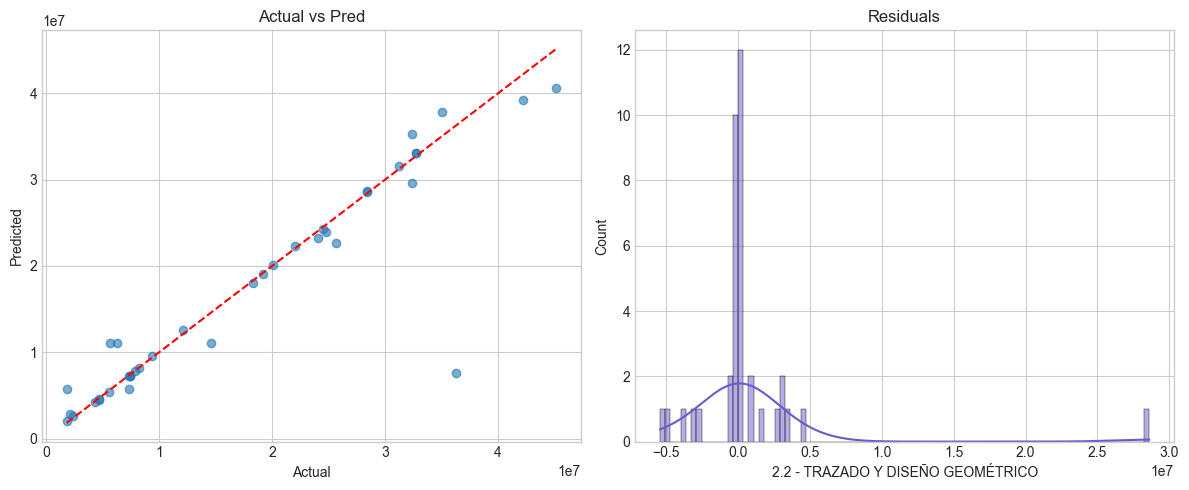

In [42]:
def calculate_metrics(df, target_columns, predictor_name, hue_name):

    for target_name in target_columns:
        df_item = df.loc[:, [predictor_name, hue_name, target_name]]
        df_item_cleaned = remove_outliers(df_item, target_name) 
        # df_item_cleaned = remove_outliers(df_item, target_name, method='all_strict') 
        # preproccesing.show_plots_eda(predictor_name, target_name, hue_name, df_item_cleaned)
        print(target_name)
        X, y, y_predicted = train_model(df_item_cleaned, predictor_name, hue_name, target_name)
        if target_name == '2.2 - TRAZADO Y DISEÑO GEOMÉTRICO':
            break
    return X, y, y_predicted    

predictor_name = 'LONGITUD KM'
hue_name = 'ALCANCE'

# ['LONGITUD KM', 'ALCANCE', '1 - TRANSPORTE', '2.1 - INFORMACIÓN GEOGRÁFICA', '2.2 - TRAZADO Y DISEÑO GEOMÉTRICO',
#        '2.3 - SEGURIDAD VIAL', '2.4 - SISTEMAS INTELIGENTES', '3.1 - GEOLOGÍA','3.2 - HIDROGEOLOGÍA', '4 - SUELOS', '5 - TALUDES', '6 - PAVIMENTO',
#        '7 - SOCAVACIÓN', '8 - ESTRUCTURAS', '9 - TÚNELES', '10 - URBANISMO Y PAISAJISMO', '11 - PREDIAL', '12 - IMPACTO AMBIENTAL',
#        '13 - CANTIDADES', '14 - EVALUACIÓN SOCIOECONÓMICA', '15 - OTROS - MANEJO DE REDES', '16 - DIRECCIÓN Y COORDINACIÓN']

target_columns = ['2.2 - TRAZADO Y DISEÑO GEOMÉTRICO', '2.3 - SEGURIDAD VIAL', '2.4 - SISTEMAS INTELIGENTES', 
                  '5 - TALUDES', '6 - PAVIMENTO', '7 - SOCAVACIÓN', '11 - PREDIAL', 
                  '12 - IMPACTO AMBIENTAL', '15 - OTROS - MANEJO DE REDES', '16 - DIRECCIÓN Y COORDINACIÓN']

X, y, y_predicted = calculate_metrics(df, target_columns, predictor_name, hue_name)    

In [50]:
X['ACTUAL'] = y
X['PREDICTED'] = y_predicted
output = X.drop(columns=['LONGITUD KM LOG'])

# Calculate various accuracy metrics for each prediction
output['APE (%)'] = (abs(X['ACTUAL'] - X['PREDICTED']) / X['ACTUAL'].replace(0, np.nan)) * 100  # Absolute Percentage Error
output['ACCURACY (%)'] = 100 - output['APE (%)']  # Accuracy as percentage

# Add quality indicators
output['WITHIN_20%'] = output['APE (%)'] <= 20  # Flag for acceptable predictions

# Display summary statistics
print("=" * 80)
print("PREDICTION ACCURACY SUMMARY")
print("=" * 80)
print(f"Mean Absolute Percentage Error (MAPE): {output['APE (%)'].mean():.2f}%")
print(f"Median Absolute Percentage Error: {output['APE (%)'].median():.2f}%")
print(f"Mean Accuracy: {output['ACCURACY (%)'].mean():.2f}%")
print(f"Predictions within ±20%: {output['WITHIN_20%'].sum()} / {len(output)} ({output['WITHIN_20%'].sum()/len(output)*100:.1f}%)")
print("=" * 80)
print()

# Sort by absolute percentage error (worst predictions first) and display
output.sort_values(by='APE (%)', ascending=False)

PREDICTION ACCURACY SUMMARY
Mean Absolute Percentage Error (MAPE): 17.29%
Median Absolute Percentage Error: 3.11%
Mean Accuracy: 82.71%
Predictions within ±20%: 31 / 38 (81.6%)



,LONGITUD KM,ALCANCE,ACTUAL,PREDICTED,APE (%),ACCURACY (%),WITHIN_20%
10,2.500,Segunda calzada,1.814013e+06,5.756294e+06,217.323680,-117.323680,False
23,5.000,Mejoramiento,5.652966e+06,1.108437e+07,96.080562,3.919438,False
25,5.243,Mejoramiento,3.623384e+07,7.620257e+06,78.969230,21.030770,False
9,5.000,Mejoramiento,6.311029e+06,1.108437e+07,75.634864,24.365136,False
34,0.910,Segunda calzada,2.126732e+06,2.802922e+06,31.794797,68.205203,False
16,6.560,Mejoramiento,1.462337e+07,1.111793e+07,23.971485,76.028515,False
27,3.120,Nuevo,7.291653e+06,5.724489e+06,21.492566,78.507434,False
24,10.060,Mejoramiento,2.561191e+07,2.266945e+07,11.488647,88.511353,True
42,1.000,Puesta a punto,2.337068e+06,2.601928e+06,11.332991,88.667009,True
32,19.310,Puesta a punto,4.512879e+07,4.066980e+07,9.880573,90.119427,True
